In [114]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import scipy.stats as st

In [115]:
# Modelo lineal
def model(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

In [116]:
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line

In [117]:
L = 1. #Range of x-data
M = 100 # Number of data points
x = np.sort(L * np.random.rand(M)) # their x-coordinates

In [118]:
sigma = 0.5 # standard deviation of the noise
data = model(x, m_true, c_true) + sigma * np.random.randn(M)


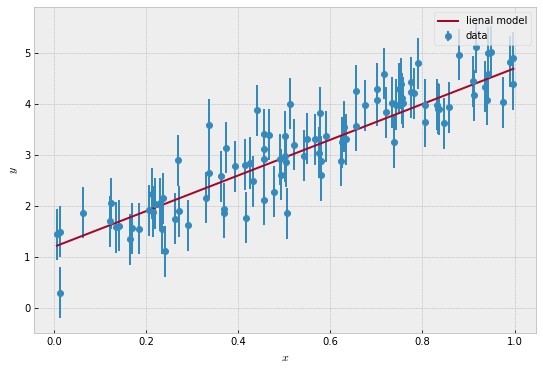

In [119]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
plt.plot(x, model(x, m_true, c_true), '-', lw=2, label='lienal model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [120]:
def logprior(theta):
    prior = 0
    m, c = theta
    clims = [-10,10]
    mlims = [-10,10]
    prior = 0 if clims[0] < c < clims[1] else -np.inf
    prior += 0 if mlims[0] < m < mlims[1] else -np.inf
    return prior

In [121]:
def likelihood(theta, data, sigma, x):
    c,m = theta
    lin_md = model(x, m, c)
    difDatos = lin_md - data
    arg = difDatos/sigma**2
    loglikelihood = -0.5 * np.sum(arg)
    return loglikelihood

In [122]:
def logpost(theta, data, sigma, x):
    return logprior(theta) + likelihood(theta, data, sigma, x)

In [123]:
def getSamples(nwalkers):
    theta0 = []
    for j in range(nwalkers): theta0.append(10*(np.random.rand())) 
    i = 0
    theta1 = []
    for j in range(nwalkers): theta1.append(10*(np.random.rand())) 
    return np.array([theta0,theta1])


In [124]:
def guassian_proposal(theta_curr):
    theta = []
    theta.append(10*(np.random.rand())) 
    theta.append(10*(np.random.rand()))
    return theta

def guassian_proposal_prob(x1, x2):
    q = np.abs(st.norm(loc=x1, scale=1).pdf(x2))
    return q

def mcmc_mh_posterior(X, theta_init,sigma,x,nwalkers,func, proposal_func, proposal_func_prob, n_iter=1000):
    chains = []
    for j in range(nwalkers):
        thetas = []
        theta_curr = theta_init.T[j]
        accept_rates = []
        accept_cum = 0
        acceptance_prob = np.array([[0,0]])
        for i in range(1, n_iter+1):
            theta_new = proposal_func(theta_curr)

            prob_curr = func(theta_curr,X,sigma,x)
            # print('theta_new',theta_new)
            prob_new = func(theta_new,X,sigma,x)
            
            if prob_new > prob_curr:
                acceptance_ratio = 1,1
            else:
                qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
                # print('qr',qr)
                acceptance_ratio = np.exp(prob_new - prob_curr) * qr
                
            acceptance_prob = np.append(acceptance_prob,[[min(1, acceptance_ratio[0]),min(1, acceptance_ratio[1])]], axis = 0)

            if acceptance_prob[i][0] > .6*acceptance_prob[i-1][0] and  acceptance_prob[i][0] > .6*acceptance_prob[i-1][1]:
                theta_curr = theta_new
                accept_cum = accept_cum+1
                # print('acc theta_new',theta_new)
                thetas.append(theta_new)
            else:
                thetas.append(theta_curr)
                
            accept_rates.append(accept_cum/i)
        chains.append(thetas)
        
    return chains, accept_rates


# generate observed data
X = data
nwalkers = 10
ndim = 2
cmin = .5
cmax = 1.5
mmin = 2
mmax = 5
initSamples = getSamples(nwalkers)
thetas, accept_rates = mcmc_mh_posterior(X, initSamples,sigma,x, nwalkers,
                                         logpost, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=10000)

In [125]:
m_theta = []
c_theta = []
chains = []
for i in range(nwalkers):
    m_theta = []
    c_theta = []
    for j in range(len(thetas[0])):
        c_theta.append(thetas[i][j][0])
        m_theta.append(thetas[i][j][1])
    chains.append([c_theta,m_theta]) 

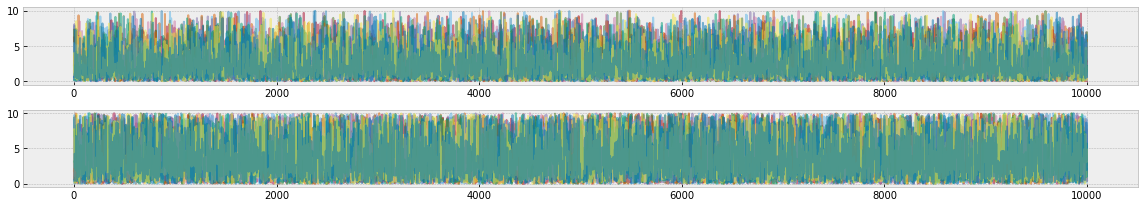

In [126]:


plt.figure(figsize=(16,1.5*ndim))

for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    for i in range(nwalkers):
        plt.plot(chains[i][n][:], '-',alpha=0.5)
plt.tight_layout()
plt.show()

In [127]:
import seaborn as sns
import pandas
m = []
c = []
for i in range(len(chains[0][0])):
    meanM = []
    meanC = []
    for j in range(nwalkers):
        meanM.append(chains[j][1][i])
        meanC.append(chains[j][0][i])
    m.append(np.mean(meanM))
    c.append(np.mean(meanC))
m_fit = max(m)
c_fit = max(c) 
print(m_fit)

d = {'c': c, 'm': m}
c_fit = max(d['c']) 
chainData = pandas.DataFrame(d)
c_fit = np.percentile(chainData['c'].to_numpy(), 40)
m_fit = np.percentile(chainData['m'].to_numpy(), 50)
print('c_fit',c_fit)


6.8723500716289605
c_fit 1.9971606318015014


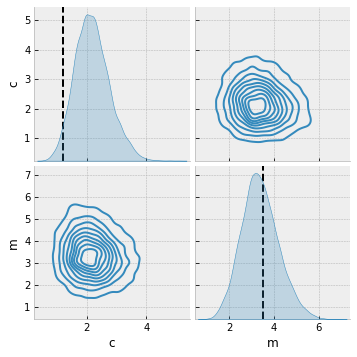

In [128]:
#sns.pairplot(chainData, kind="kde")
plt.style.use('bmh')
g = sns.pairplot(chainData, kind="kde")
i = 0
for ax in g.axes.ravel():
    if i == 0: ax.axvline(x=c_true, ls='--', linewidth=2, c='black',label='True c')
    if i == 3: ax.axvline(x=m_true, ls='--', linewidth=2, c='black',label='True m')
    i += 1
plt.show()


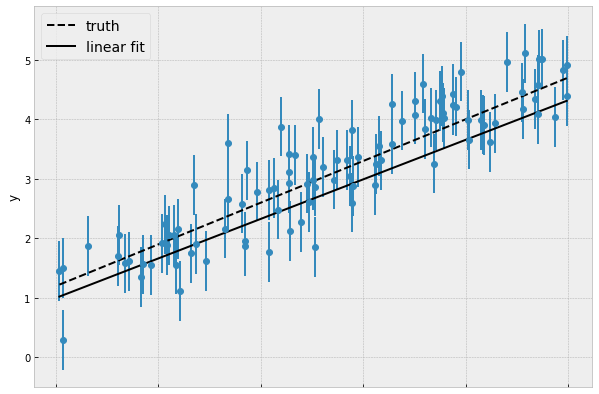

In [129]:
###
fig,ax1=plt.subplots(1,1,figsize=(10,7))
gs=gridspec.GridSpec(1,1)
colors=['b','orange']
###

ax1=plt.subplot(gs[0])

ax1.errorbar(x, data, yerr=sigma, fmt="o")
ax1.plot(x, model(x,m_true,c_true), 'k--', label="truth")
ax1.plot(x, model(x,m_fit,1), 'k', label="linear fit")


###

ax1.legend(fontsize=14)
models = ['linear model', 'quadratic model']
ax1.set_ylabel(r'y')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)